<a href="https://colab.research.google.com/github/KimaniKibuthu/Taxi-fare-prediction/blob/main/Taxi_Fare_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taxi Fare Prediction
You are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations.

**Features**

**key** - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field. Required in your submission CSV. Not necessarily needed in the training set, but could be useful to simulate a 'submission file' while doing cross-validation within the training set.

**pickup_datetime** - timestamp value indicating when the taxi ride started.

**pickup_longitude** - float for longitude coordinate of where the taxi ride started.

**pickup_latitude** - float for latitude coordinate of where the taxi ride started.

**dropoff_longitude** - float for longitude coordinate of where the taxi ride ended.

**dropoff_latitude** - float for latitude coordinate of where the taxi ride ended.

**passenger_count** - integer indicating the number of passengers in the taxi ride.


**Target**

**fare_amount** - float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.



The project will be divided into the following stages:
* Data Obtainance
* Data Cleaning and Exploration
* Feature Engineering
* Modelling

# Libraries and Variables

## Libraries
The libraries used.

In [1]:

!pip install --upgrade kaggle

Requirement already up-to-date: kaggle in /usr/local/lib/python3.7/dist-packages (1.5.12)


In [2]:
!pip install catboost

In [3]:
# General libraries
import os
import numpy as np
import pandas as pd
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, Mi
from geopy.geocoders import Nominatim



# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling Libraries

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score


## Variables and Functions
The variables used.

In [4]:
RANDOM_STATE = 42

traintypes = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}
              
cols = list(traintypes.keys())

In [5]:
# Check for nulls
def null_handler(data):
  data = data.dropna().drop_duplicates().reset_index(drop=True)
  return data


In [6]:
# Function to create new columns and extract data from pick up date

def time_column_generator(time_column, data):
  '''
  It extracts information from the time column to return a new dataset with 
  new columns consisting of year, month, day, holiday, weekend, hour and minute.

  **Parameters**:
  time_column: str 
      The time column 
  
  data: DataFrame
      The dataframe containing the time column

  **Returns**:
  New dataset with new column
  '''

  time_values = data[time_column].values
  pre_time = [value.split(sep=' ', maxsplit=2)[:2] for value in time_values]
  time = [' '.join(value) for value in pre_time]

  month = [datetime.strptime(value, '%Y-%m-%d %H:%M:%S').month for value in time]
  year = [datetime.strptime(value, '%Y-%m-%d %H:%M:%S').year for value in time]
  day = [datetime.strptime(value, '%Y-%m-%d %H:%M:%S').day for value in time]
  hour = [datetime.strptime(value, '%Y-%m-%d %H:%M:%S').hour for value in time]
  minute = [datetime.strptime(value, '%Y-%m-%d %H:%M:%S').minute for value in time]
  day_of_week = [datetime.strptime(value, '%Y-%m-%d %H:%M:%S').isoweekday() for value in time]


  data['hour'] = hour
  data['minute'] = minute
  data['month'] = month
  data['year'] = year
  data['day'] = day
  data['time'] = pd.Series(time, dtype='datetime64[ns]')
  data['day_of_week'] = day_of_week

  cal = USFederalHolidayCalendar()
  start = datetime(2008, 1, 1)
  end = datetime(2019, 12, 31)
  holidays = cal.holidays(start=start, end=end)
  is_holiday = [1 if value in holidays else 0 for value in data['time'].values]
  
  data['is_holiday'] = is_holiday


  return data



In [7]:
# Percentile range
def outlier_remover(columns, data):
  '''
  Removes outliers in the data
  '''

  for column in columns:
    median = data[column].median()
    upper, lower = median + 0.3, median - 0.3 #np.percentile(data[column], [1,99])
    data[column] = np.clip(data[column], upper, lower)

  return data

In [8]:
def distance_getter(data):
  '''
  Creates the distance column
  '''
  
  from geopy.distance import geodesic
  from geopy.extra.rate_limiter import RateLimiter
  geocoder = Nominatim(user_agent="my-application")
  geocode = RateLimiter(geocoder.geocode, min_delay_seconds = 1,
                        return_value_on_exception = None) 
  

  pickup_latitudes = data['pickup_latitude'].values
  pickup_longitudes = data['pickup_longitude'].values
  dropoff_latitudes = data['dropoff_latitude'].values
  dropoff_longitudes = data['dropoff_longitude'].values

  pickup_coordinates = list(zip(pickup_latitudes, pickup_longitudes))
  dropoff_coordinates = list(zip(dropoff_latitudes, dropoff_longitudes))

  distance = [ geodesic(x,y).km  for x, y in zip(pickup_coordinates, dropoff_coordinates)]
  #pickup_road = [geocoder.reverse(value).raw['address']['road'] for value in pickup_coordinates]
  #dropoff_road = [geocoder.reverse(value).raw['address']['road'] for value in dropoff_coordinates]
  #pickup_suburb = [geocoder.reverse(value).raw['display_name'].split(', ')[2] for value in pickup_coordinates]
  #dropoff_suburb = [geocoder.reverse(value).raw['display_name'].split(', ')[2] for value in dropoff_coordinates]

  data['distance'] = distance
  #data['pickup_road'] = pickup_road
  #data['dropoff_road'] = dropoff_road
  #data['pickup_suburb'] = pickup_suburb
  #data['dropoff_suburb'] = dropoff_suburb

  return data

In [9]:
# Lat and longitude

def coordinate_fixer(data):
  '''
  Gets the 3D positioning from the coordinates
  '''
  
  data['dropoff_x'] = np.cos(data['dropoff_latitude']) * np.cos(data['dropoff_longitude'])
  data['dropoff_y'] = np.cos(data['dropoff_latitude']) * np.sin(data['dropoff_longitude'])
  data['pickup_x'] = np.cos(data['pickup_latitude']) * np.cos(data['pickup_longitude'])
  data['pickup_y'] = np.cos(data['pickup_latitude']) * np.sin(data['pickup_longitude'])
  data['pickup_z'] = np.sin(data['pickup_latitude'])
  data['dropoff_z'] = np.sin(data['dropoff_latitude'])
  
  return data




In [10]:
## define a model Trainer
def model_trainer(models, x_train, y_train, x_val, y_val):
  '''
  Trains the model
  '''
  
  for model in models:
    model.fit(x_train, y_train)
    predictions = model.predict(x_val)
    rmse = mean_squared_error(y_val, predictions, squared=False)
    r2 = r2_score(y_val, predictions)
    

    print(f'Model {model} , rmse: {rmse}, r2_score: {r2}')

In [11]:
# View feature importance
def plot_feature_importance(trained_model, features_train):

    #Create arrays from feature importance and feature names
    feature_importance = trained_model.feature_importances_
    feature_names = features_train.columns

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.set_style('whitegrid')
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],
                palette='husl')
    #Add chart labels
    plt.title('FEATURE IMPORTANCES')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [12]:
def rmse(y_true, y_pred):
  return tf.math.sqrt(tf.keras.losses.MSE(y_true, y_pred))

In [13]:
def plot_interactive_figures(model_history, metric, all=True, test_data=True):
    """
    Plot the performance metrics of the model


    :param model_history: history

    The model history obtained from model.fit()

    :param metric: str
    The performance metric you want to use.**loss**, **accuracy**

    :param all: bool
    default=True. If true, overrides metric and plots figures of accuracy and loss.
    If false, plots the metric defined.

    :param test_data: bool
    default = True.
    If you have used validation data or not

    :return:
    Performance of the model
    """

    import plotly.graph_objects as go

    if all:
        if test_data:
            acc = model_history.history['accuracy']
            val_acc = model_history.history['val_accuracy']

            loss = model_history.history['loss']
            val_loss = model_history.history['val_loss']
            epochs = list(range(len(acc)+1))
            # Plots
            ax = go.Figure()
            ax.add_trace(go.Scatter(x=epochs, y=val_acc, name='Validation Accuracy',
                                    line=dict(color='yellow', width=4)))
            ax.add_trace(go.Scatter(x=epochs, y=acc, name='Train Accuracy',
                                    line=dict(color='blue', width=4)))
            ax.update_layout(title='Train and Validation Accuracy plots',
                             xaxis_title='Epochs',
                             yaxis_title='Accuracy')
            ax.show()

            bx = go.Figure()
            bx.add_trace(go.Scatter(x=epochs, y=val_loss, name='Validation Loss',
                                    line=dict(color='yellow', width=4)))
            bx.add_trace(go.Scatter(x=epochs, y=loss, name='Train Loss',
                                    line=dict(color='blue', width=4)))
            bx.update_layout(title='Train and Validation Loss plots',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            bx.show()

        if not test_data:
            acc = model_history.history['accuracy']
            loss = model_history.history['loss']
            epochs = list(range(len(acc)+1))

            cx = go.Figure()
            cx.add_trace(go.Scatter(x=epochs, y=acc, name='Accuracy',
                                    line=dict(color='blue', width=4)))
            cx.update_layout(title='Accuracy plot',
                             xaxis_title='Epochs',
                             yaxis_title='Accuracy')
            cx.show()

            dx = go.Figure()
            dx.add_trace(go.Scatter(x=epochs, y=loss, name='Loss',
                                    line=dict(color='yellow', width=4)))
            dx.update_layout(title='Loss plot',
                             xaxis_title='Epochs',
                             yaxis_title='Loss')
            dx.show()

    if not all:
        if test_data:
            value_train = model_history.history[metric]
            value_test = model_history.history['val_{}'.format(metric)]
            epochs = list(range(len(value_train)+1))

            ex = go.Figure()
            ex.add_trace(go.Scatter(x=epochs, y=value_test, name='Validation {}'.format(metric),
                                    line=dict(color='yellow', width=4)))
            ex.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            ex.update_layout(title='Train and Validation {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            ex.show()

        if not test_data:
            value_train = model_history.history[metric]
            epochs = list(range(len(value_train)+1))

            fx = go.Figure()
            fx.add_trace(go.Scatter(x=epochs, y=value_train, name='Train {}'.format(metric),
                                    line=dict(color='blue', width=4)))
            fx.update_layout(title='Train {} plots'.format(metric),
                             xaxis_title='Epochs',
                             yaxis_title='{}'.format(metric))
            fx.show()


# Data Obtainance
Obtain the data from kaggle.

In [14]:
# Kaggle details
os.environ["KAGGLE_USERNAME"] = 'kimanikibuthu'
os.environ["KAGGLE_KEY"] = 'f85c0bb5d43058fddcce7902e1325677'

In [15]:
# Download data
!kaggle competitions download -c new-york-city-taxi-fare-prediction

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
GCP-Coupons-Instructions.rtf: Skipping, found more recently modified local copy (use --force to force download)


In [16]:
# Unzip the train
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [17]:
# Save in variables. Taking a sample size of train
train = pd.read_csv('/content/train.csv', usecols=cols, dtype=traintypes,
                    nrows=5000000)
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

# Data Cleaning and Exploration


## General Exploration


In [18]:
# Look at a sample
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968094,40.768009,-73.956657,40.783764,1


In [19]:
# Drop duplicates
train = null_handler(train)

In [20]:
# General info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999946 entries, 0 to 4999945
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   fare_amount        float32
 1   pickup_datetime    object 
 2   pickup_longitude   float32
 3   pickup_latitude    float32
 4   dropoff_longitude  float32
 5   dropoff_latitude   float32
 6   passenger_count    uint8  
dtypes: float32(5), object(1), uint8(1)
memory usage: 138.3+ MB


In [21]:
# General description
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4.999946e+06,4.999946e+06,4.999946e+06,4.999946e+06,4.999946e+06,4.999946e+06
mean,1.132030e+01,-7.128668e+01,4.173930e+01,-7.128648e+01,4.173633e+01,1.684708e+00
std,9.774993e+00,1.263775e+01,9.093510e+00,1.268466e+01,9.608500e+00,1.331852e+00
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075264e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.310365e+03,3.457622e+03,3.345917e+03,2.080000e+02


### Pickup Datetime
Let's obtain some information on this column. 

In [22]:
# Generate time columns
after_time_train = time_column_generator('pickup_datetime', train)

[Text(0, 0.5, 'fare'), Text(0.5, 1.0, 'Fare vs time')]

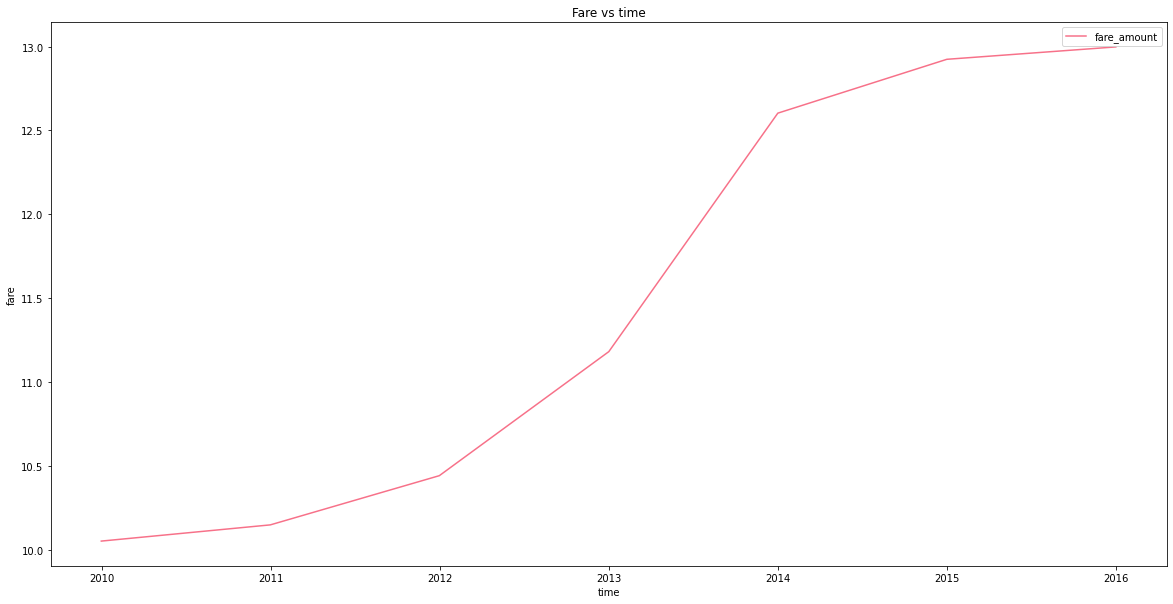

In [23]:
# Visualize effect of price and date

# Create a subset to visualize
subset = after_time_train[['time', 'fare_amount']]
subset = subset.set_index(subset['time'], drop=True)
subset_mean = subset.resample('A').mean()

# Plot

plt.figure(figsize=(20, 10))
sns.lineplot(data=subset_mean, palette='husl').set(ylabel='fare', 
                                                   title='Fare vs time')

[Text(0, 0.5, 'fare'), Text(0.5, 1.0, 'Fare vs time')]

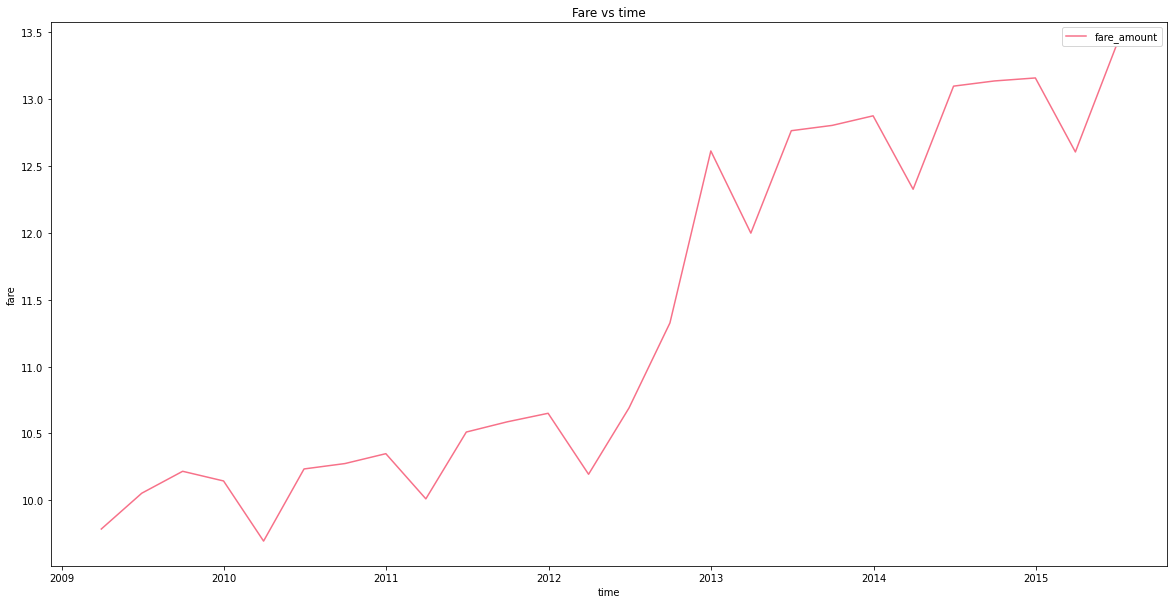

In [24]:
subset_mean = subset.resample('Q').mean()

# Plot

plt.figure(figsize=(20, 10))
sns.lineplot(data=subset_mean, palette='husl').set(ylabel='fare', 
                                                   title='Fare vs time')

[Text(0, 0.5, 'fare'), Text(0.5, 1.0, 'Fare vs time')]

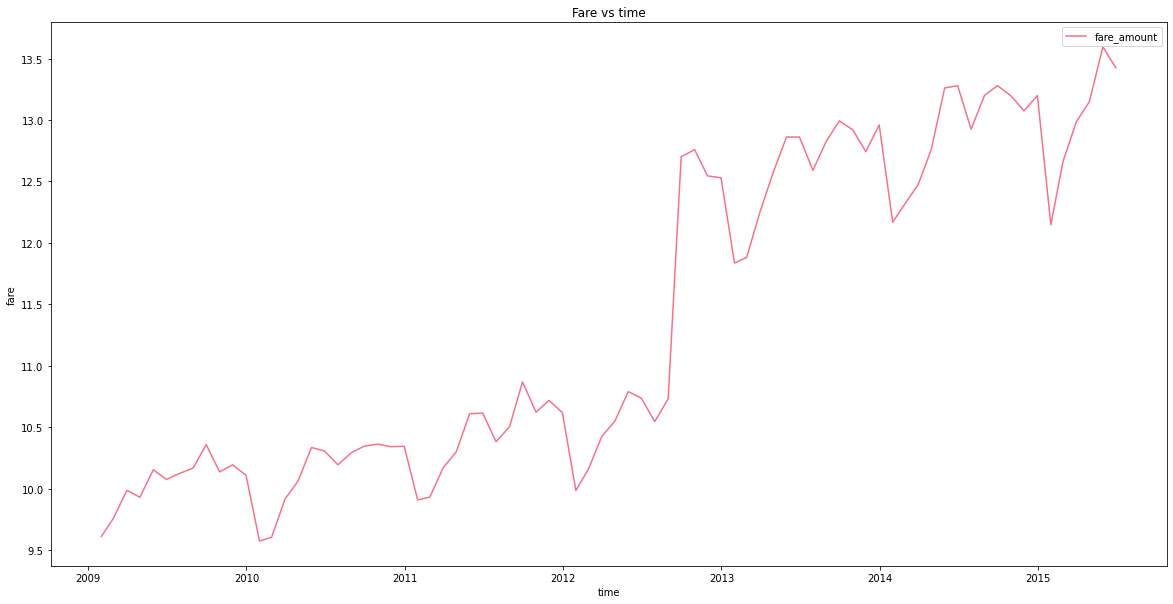

In [25]:
subset_mean = subset.resample('M').mean()

# Plot
plt.figure(figsize=(20, 10))
sns.lineplot(data=subset_mean, palette='husl').set(ylabel='fare', 
                                                   title='Fare vs time')

From the images above it is clear that the fare price increased from **2010** to **2016** with a sharp increase in **2012**.

In every year, there was a dip in the fare amount in a certain quarter, particularly the first quarter.





[Text(0.5, 1.0, 'Fare vs Day of Week')]

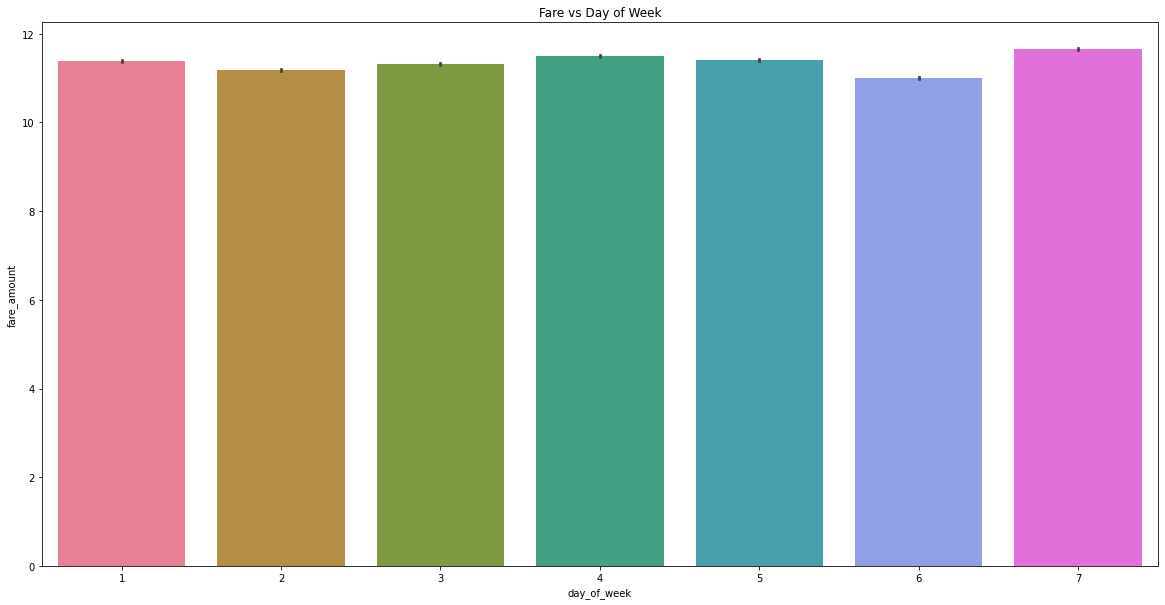

In [26]:
# Day of the week and price

plt.figure(figsize=(20, 10))
sns.barplot(x='day_of_week', y = 'fare_amount',
            palette='husl',
            data=after_time_train).set(title='Fare vs Day of Week')

[Text(0.5, 1.0, 'Day of Week Count')]

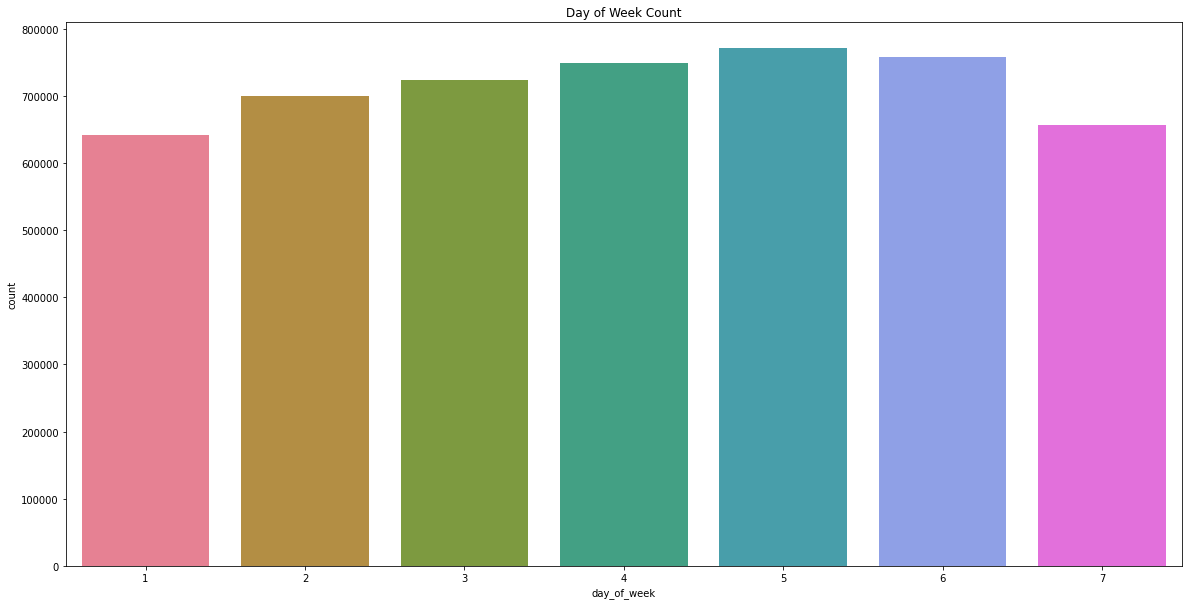

In [27]:
# Count vs Day of the week

plt.figure(figsize=(20, 10))
sns.countplot(x='day_of_week',
            palette='husl',
            data=after_time_train).set(title='Day of Week Count')

The day of the week does not seem to affect the change in price of the fares.


[Text(0.5, 1.0, 'Fare vs Holiday')]

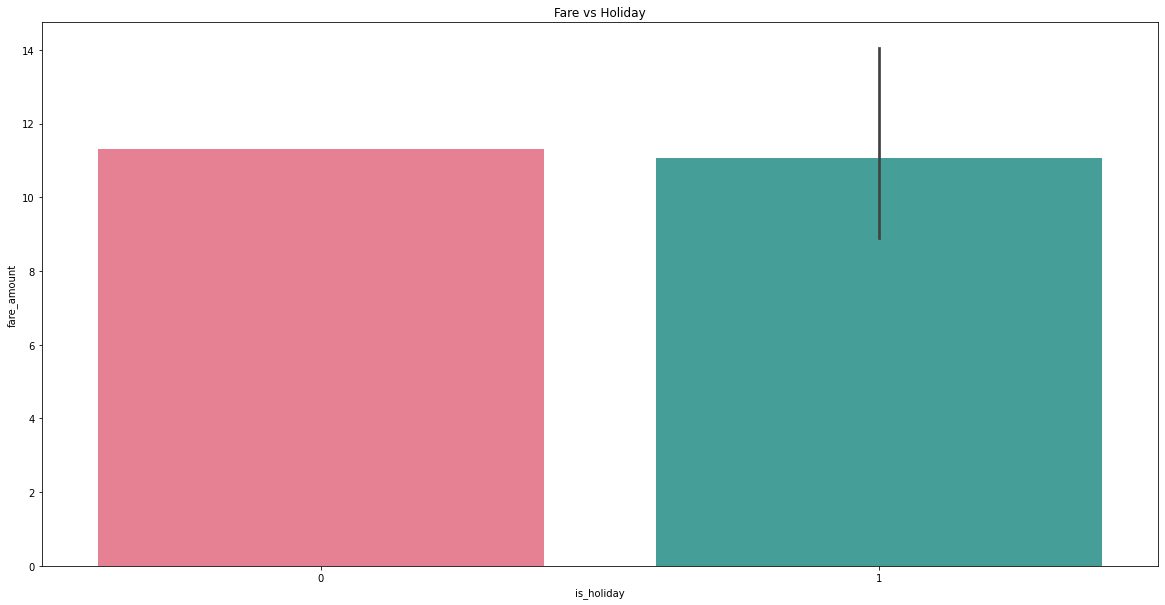

In [28]:
# Holiday vs Fare
plt.figure(figsize=(20, 10))
sns.barplot(x='is_holiday', y = 'fare_amount',
            palette='husl',
            data=after_time_train).set(title='Fare vs Holiday')

[Text(0.5, 1.0, 'Count of Holiday')]

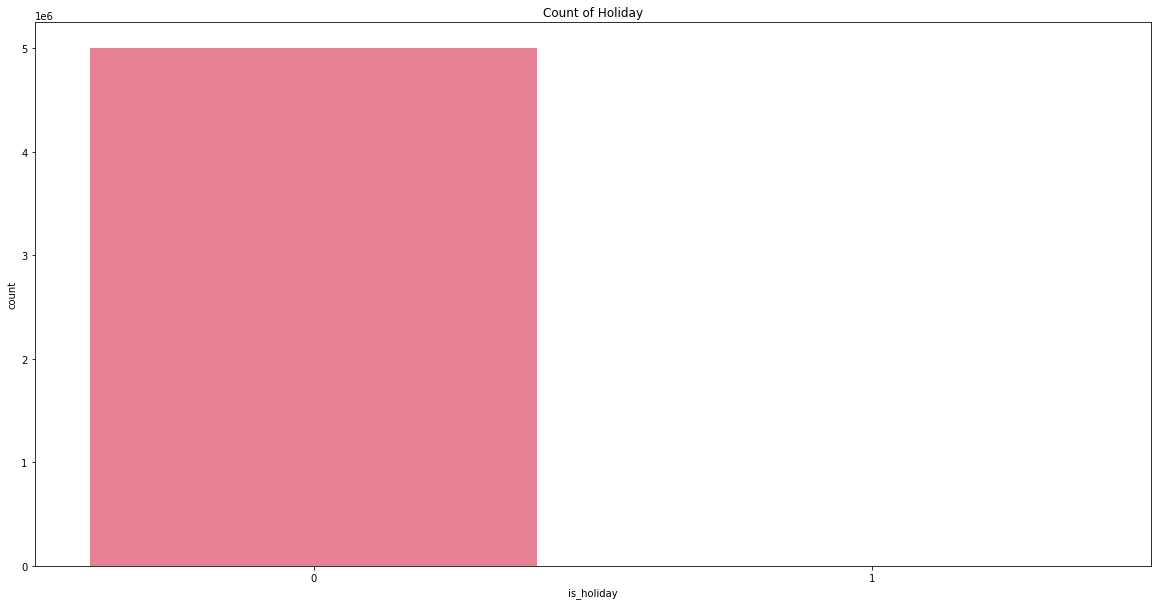

In [29]:
# Holiday

plt.figure(figsize=(20, 10))
sns.countplot(x='is_holiday',
            palette='husl',
            data=after_time_train).set(title='Count of Holiday')

In [30]:
# Check value counts
after_time_train.is_holiday.value_counts(normalize=True)

0    0.999992
1    0.000008
Name: is_holiday, dtype: float64

Only 3 days were holidays and their price varied. There isn't much disparity between a holiday and a non holiday.


[Text(0.5, 1.0, 'Fare vs Hour')]

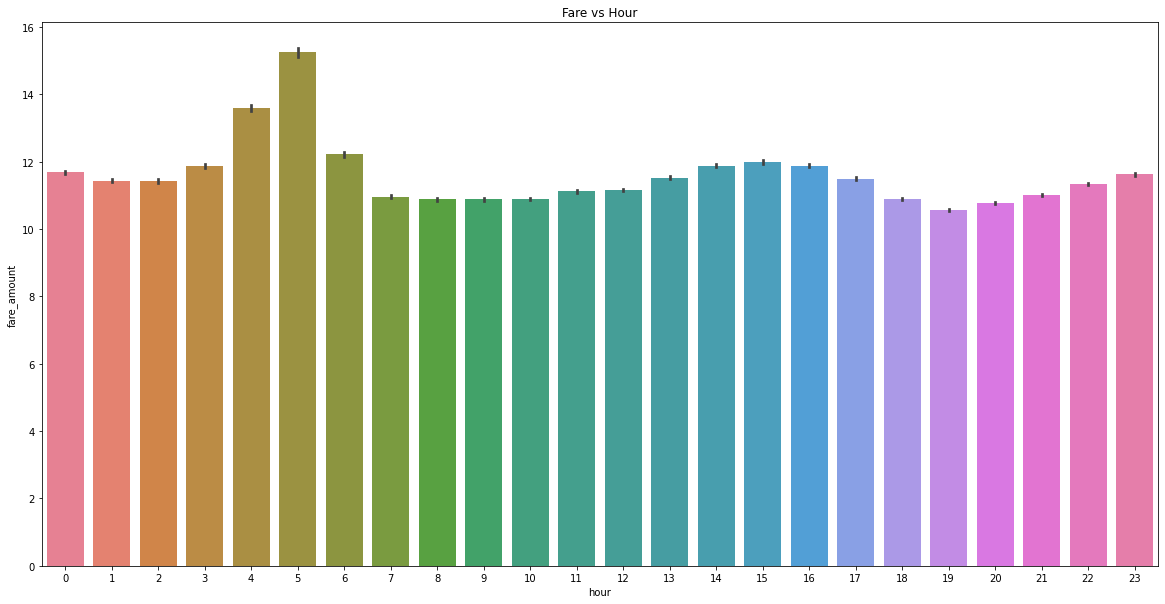

In [31]:
 # Hour vs Fare
plt.figure(figsize=(20, 10))
sns.barplot(x='hour', y = 'fare_amount',
            palette='husl',
            data=after_time_train).set(title='Fare vs Hour')

[Text(0.5, 1.0, 'Count of Hour')]

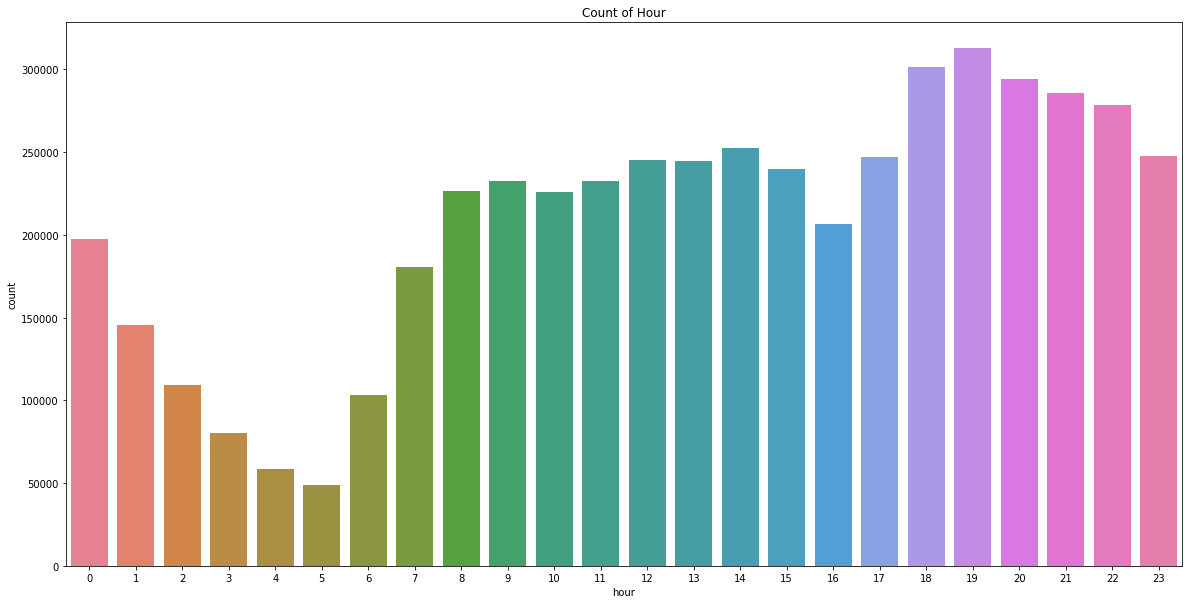

In [32]:
# Hour

plt.figure(figsize=(20, 10))
sns.countplot(x='hour',
            palette='husl',
            data=after_time_train).set(title='Count of Hour')

[Text(0.5, 1.0, 'Fare vs Hour')]

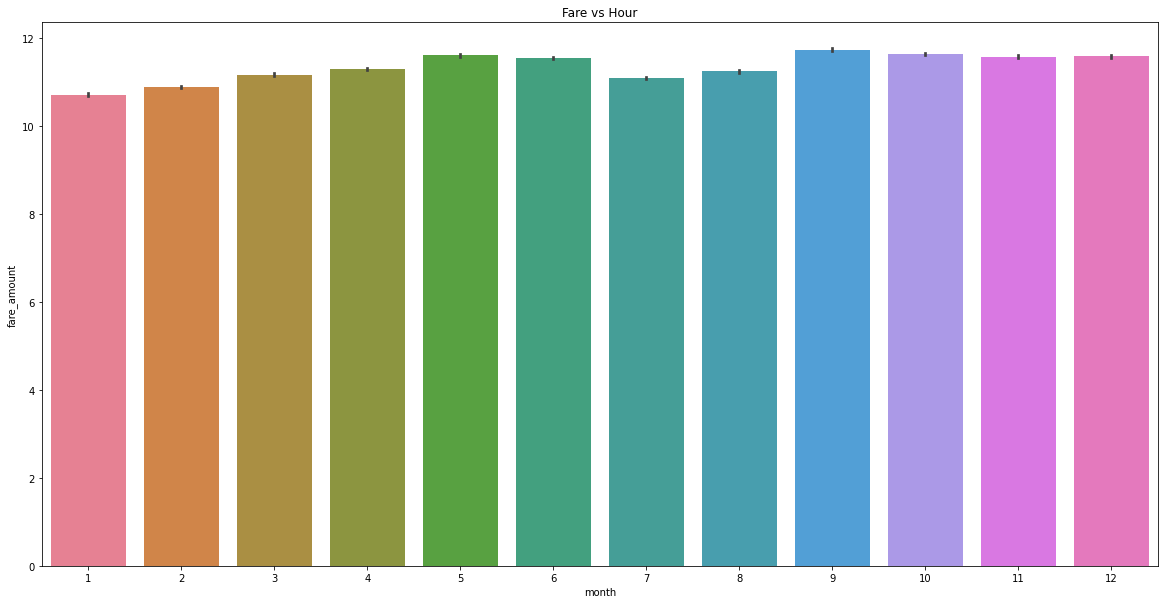

In [33]:
 # Month vs Fare
plt.figure(figsize=(20, 10))
sns.barplot(x='month', y = 'fare_amount',
            palette='husl',
            data=after_time_train).set(title='Fare vs Hour')

[Text(0.5, 1.0, 'Count of Hour')]

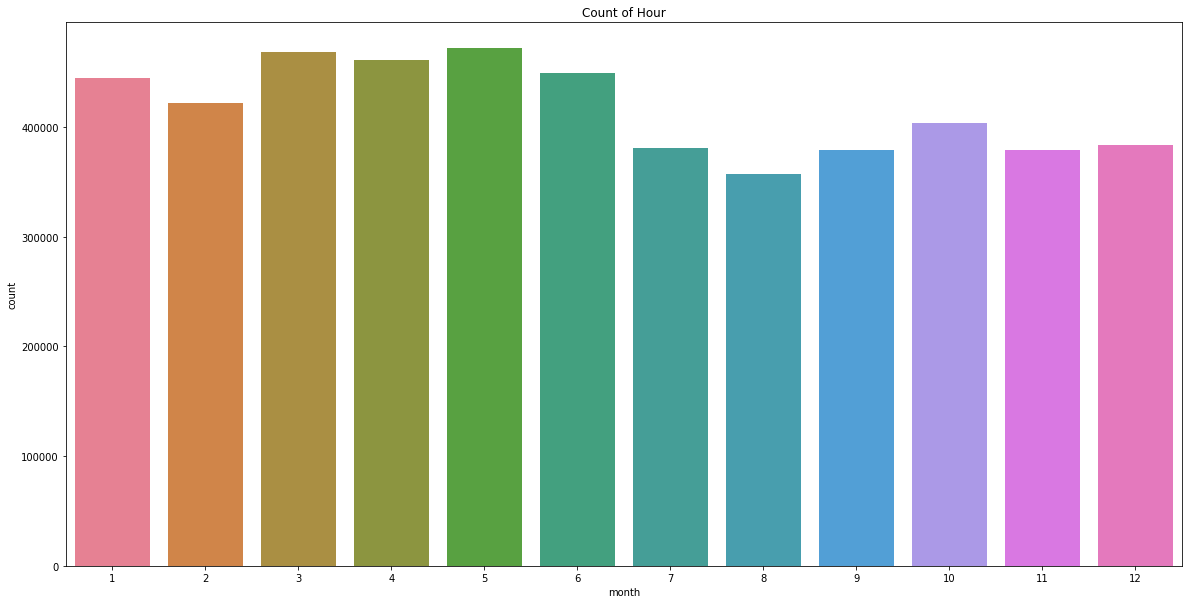

In [34]:
# Month

plt.figure(figsize=(20, 10))
sns.countplot(x='month',
            palette='husl',
            data=after_time_train).set(title='Count of Hour')

### Latitude and Latitude

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


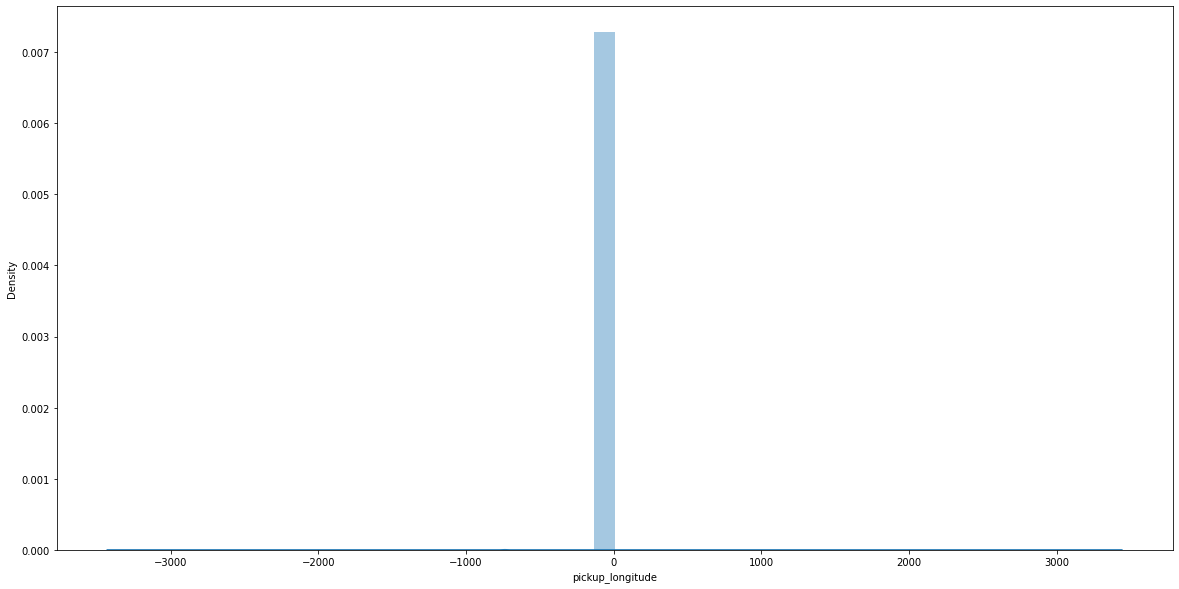

In [35]:
# Look at the distribution of lats and longitudes
plt.figure(figsize=(20, 10))
sns.distplot(after_time_train['pickup_longitude'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


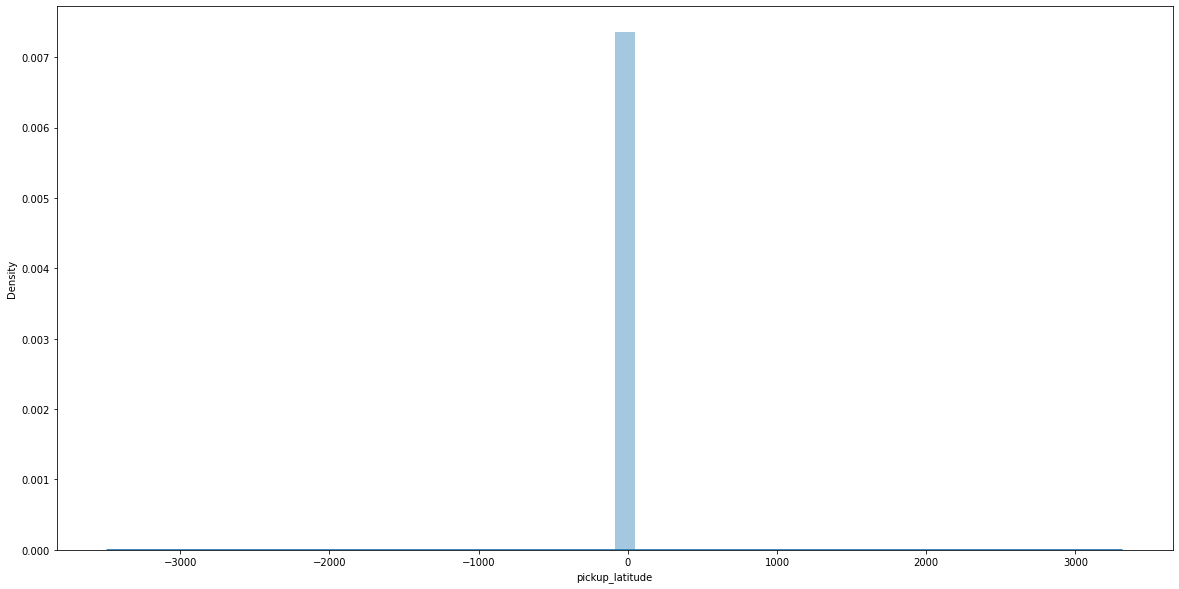

In [36]:
# Look at the distribution of lats and longitudes
plt.figure(figsize=(20, 10))
sns.distplot(after_time_train['pickup_latitude'])

There are outliers that we will need to get rid off. 

In [37]:
# Get rid of outliers
train_without_outliers = outlier_remover(['pickup_latitude', 'pickup_longitude',
                 'dropoff_latitude', 'dropoff_longitude'],
                after_time_train)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

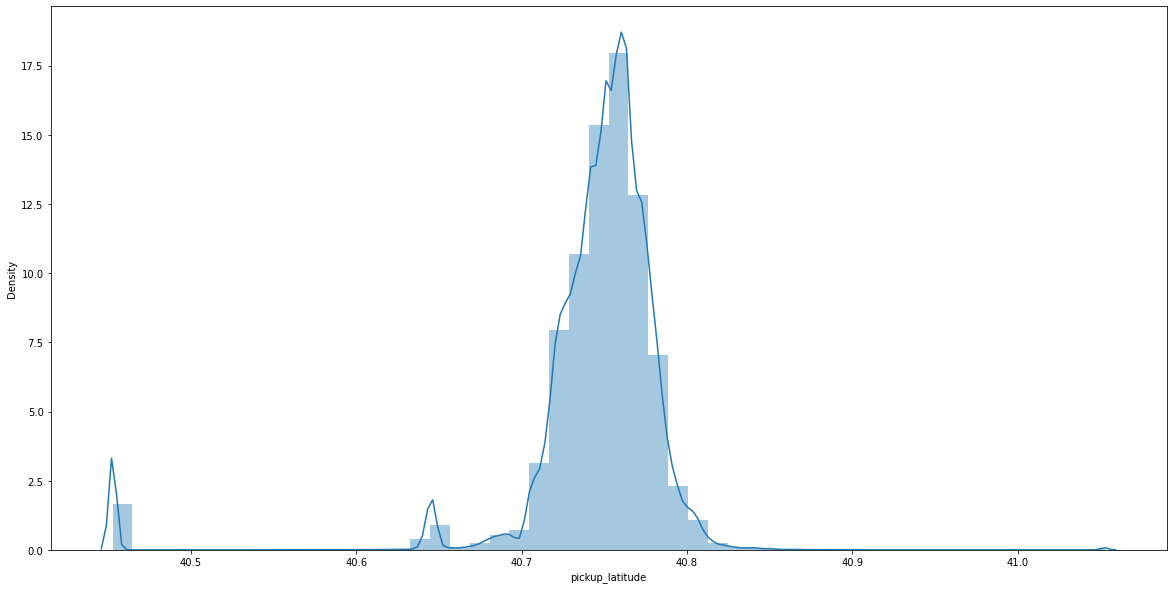

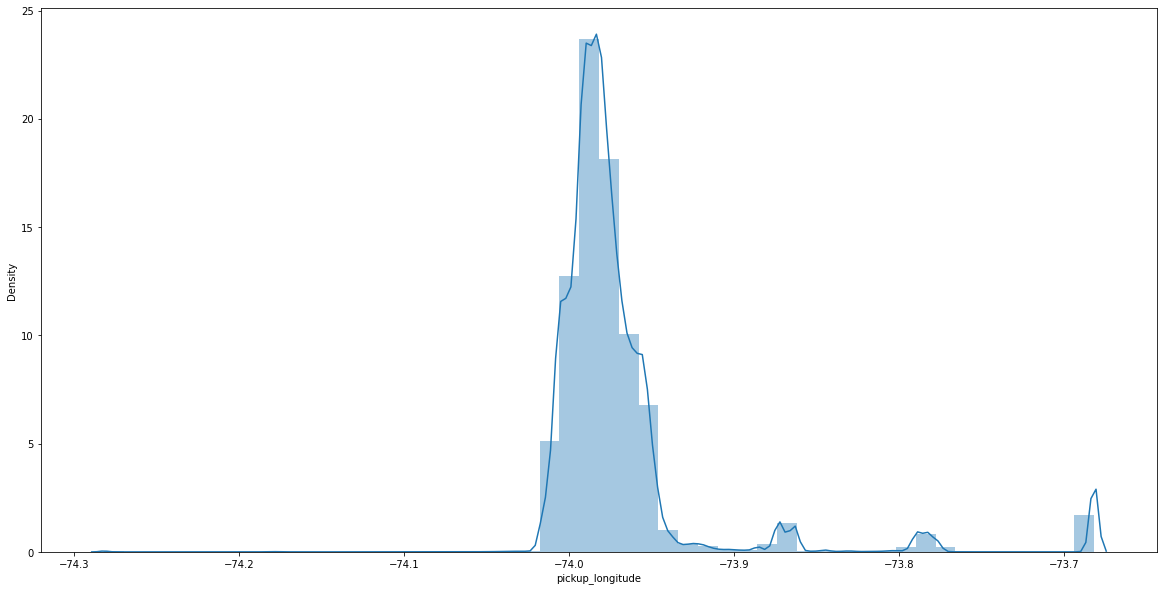

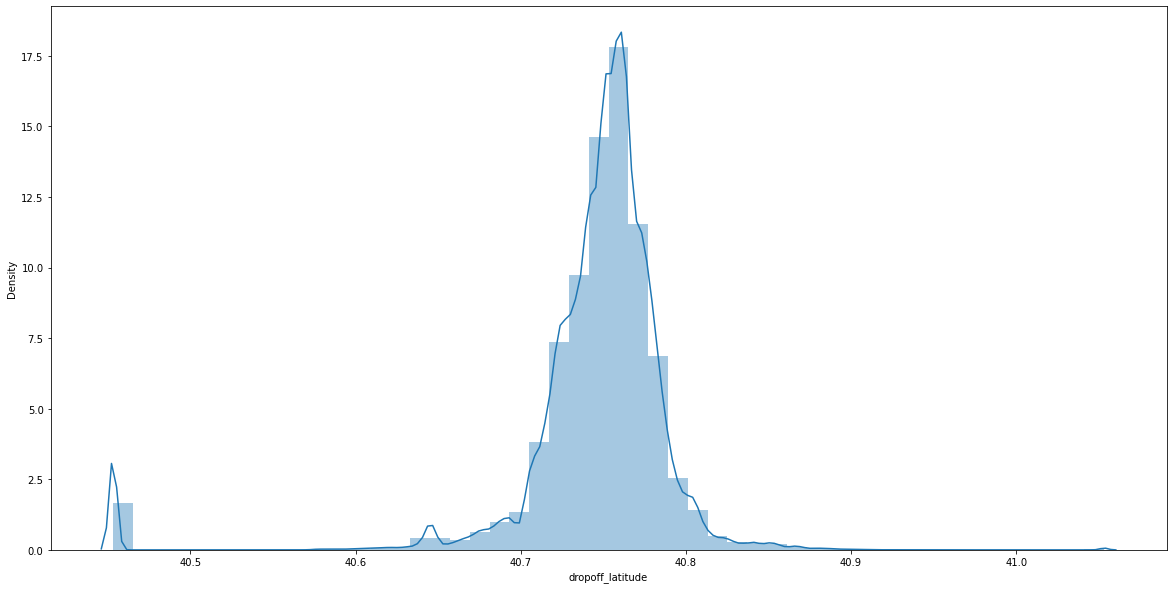

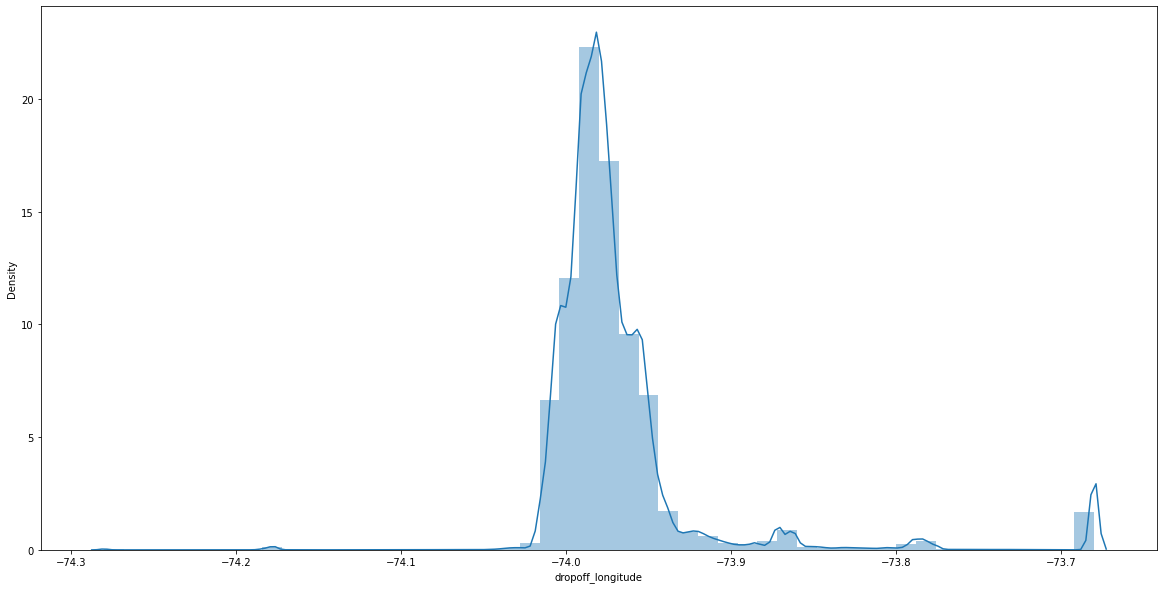

In [38]:
# Look at the distribution of lats and longitudes
for column in ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']:
  plt.figure(figsize=(20, 10))
  sns.distplot(train_without_outliers[column])

In [39]:
# Reset index
train_without_outliers.reset_index(drop=True, inplace=True)


#### Distance

In [40]:
# Create distance
train_with_distance = distance_getter(train_without_outliers)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


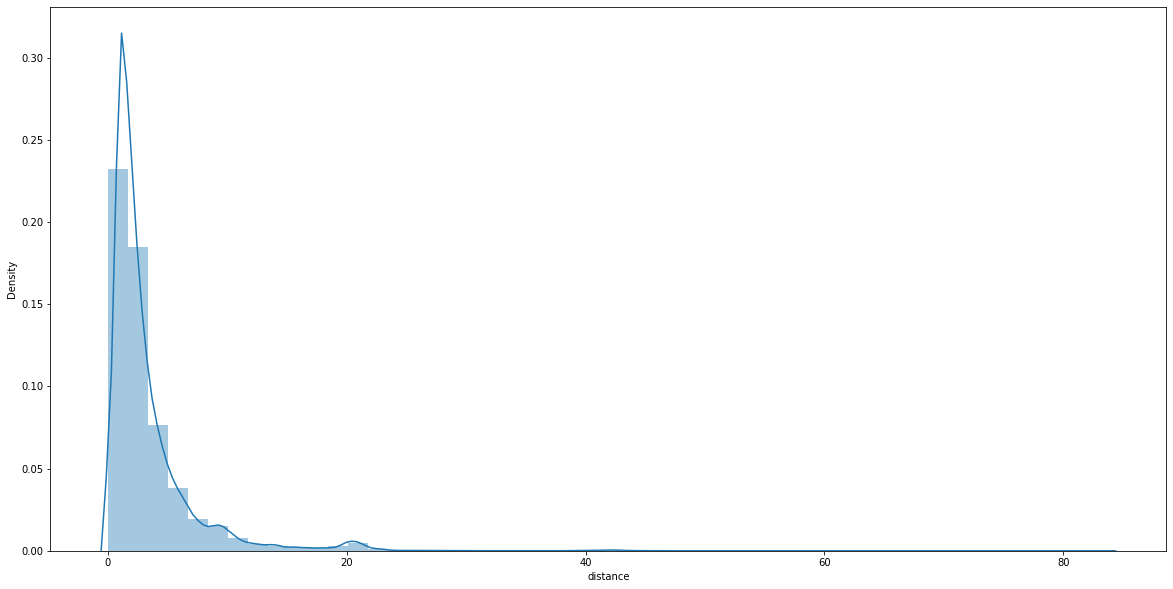

In [41]:
# Visualize  distance
plt.figure(figsize=(20, 10))
sns.distplot(train_with_distance['distance'])

### More Columns

In [42]:
# Bin distance
train_with_distance.loc[train_with_distance.distance <= 10, 'Duration_Bin'] = 'short'
train_with_distance.loc[(train_with_distance.distance > 10) & (train_with_distance.distance <= 20), 'Duration_Bin'] = 'medium'
train_with_distance.loc[train_with_distance.distance > 20, 'Duration_Bin'] = 'long'

[Text(0.5, 1.0, 'Duration')]

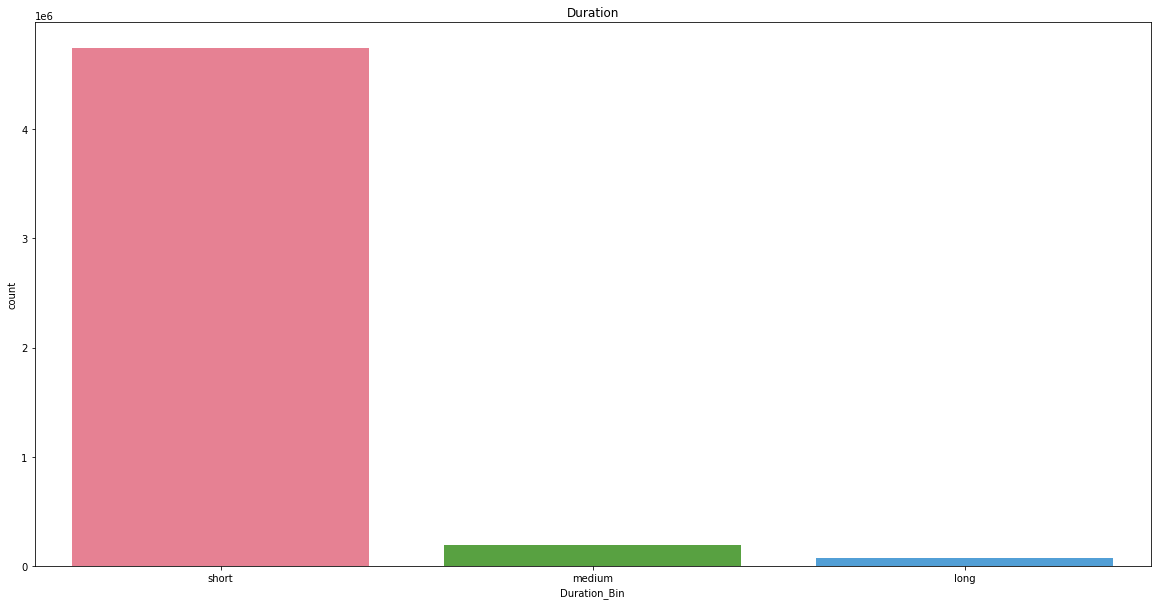

In [43]:
# Visualize
plt.figure(figsize=(20, 10))
sns.countplot(x='Duration_Bin',
            palette='husl',
            data=train_with_distance).set(title='Duration')

In [44]:
# hour bin
train_with_distance.loc[train_with_distance.hour <= 5 , 'hour_bin'] = 'em'
train_with_distance.loc[(train_with_distance.hour > 5) & (train_with_distance.hour <= 12), 'hour_bin'] = 'm'
train_with_distance.loc[(train_with_distance.hour > 12) & (train_with_distance.hour <= 18), 'hour_bin'] = 'af'
train_with_distance.loc[(train_with_distance.hour > 18) & (train_with_distance.hour <= 23), 'hour_bin'] = 'n'

[Text(0.5, 1.0, 'Duration')]

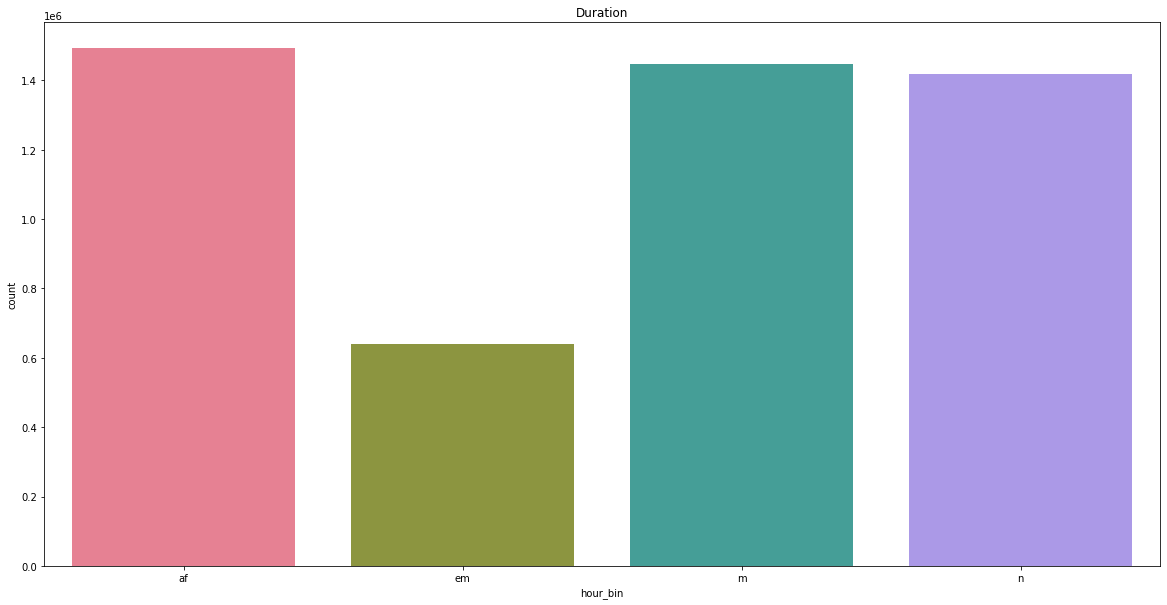

In [45]:
# Visualize
plt.figure(figsize=(20, 10))
sns.countplot(x='hour_bin',
            palette='husl',
            data=train_with_distance).set(title='Duration')

In [46]:
# Get coordinates in 3D
train_with_distance = coordinate_fixer(train_with_distance)

In [47]:
# Encode data
cat_columns = [x for x in train_with_distance.columns if train_with_distance[x].dtype == 'O']

# Encode
encoder = LabelEncoder()

for column in cat_columns:
  train_with_distance[column] = encoder.fit_transform(train_with_distance[column].astype(str))

## Data Splitting

In [48]:
train_with_distance.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'hour',
       'minute', 'month', 'year', 'day', 'time', 'day_of_week', 'is_holiday',
       'distance', 'Duration_Bin', 'hour_bin', 'dropoff_x', 'dropoff_y',
       'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_z'],
      dtype='object')

In [49]:
# Choose columns
to_use = [ 'hour','month', 
       'year', 'day_of_week',
       'distance',  'dropoff_x',
       'dropoff_y', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_z']

x = train_with_distance[to_use]
y = train_with_distance['fare_amount']

In [50]:
# Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=RANDOM_STATE)

# Modelling

Modelling will be using statistical methods and using a neural network

### Statistical Modelling
The use of xgboost and catboost

In [51]:
# Define models
xgb = XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE)
cat = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)
lgb = LGBMRegressor(random_state=RANDOM_STATE)

models = [xgb, cat, lgb]

In [52]:
model_trainer(models, x_train, y_train, x_test, y_test)


Model XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1) , rmse: 4.635512828826904, r2_score: 0.7788314485273796
Model <catboost.core.CatBoostRegressor object at 0x7f25a82bbd90> , rmse: 4.2459132682865395, r2_score: 0.8144461231734288
Model LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              rand

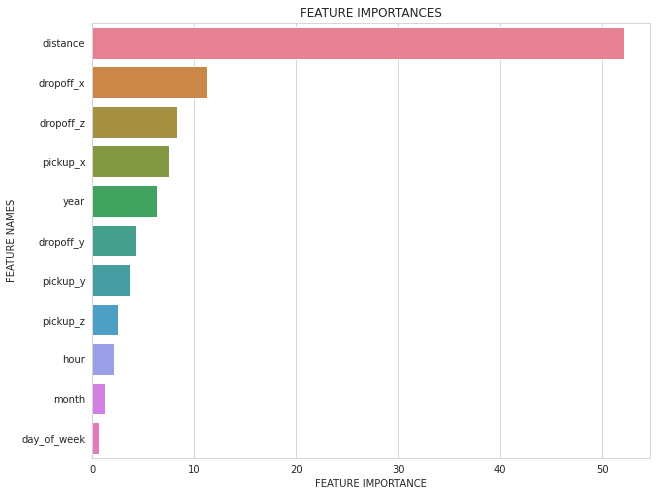

In [53]:
plot_feature_importance(cat, x_train)

## Neural Network

In [130]:
# Standardize
scaler = StandardScaler()

X_train = scaler.fit_transform(x_train)
X_test = scaler.fit_transform(x_test)

In [131]:

# Create model
model = Sequential([
    Dense(32, activation='relu', input_shape=(11,)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(units=1)
    ]
)

model.compile(loss= rmse, optimizer= tf.keras.optimizers.Adam(
    learning_rate=0.000005))

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)




In [132]:
# Train model
history = model.fit(X_train, y_train, 
                        epochs=12, batch_size=1024, 
                        validation_data = (X_test, y_test),
                        validation_steps = 512,
                        callbacks=[model_checkpoint_callback])

Epoch 1/12
3907/3907 [==============================] - 10s 2ms/step - loss: 10.7164 - val_loss: 8.7588
Epoch 2/12
3907/3907 [==============================] - 9s 2ms/step - loss: 7.7358 - val_loss: 5.3658
Epoch 3/12
3907/3907 [==============================] - 9s 2ms/step - loss: 5.1935 - val_loss: 4.3814
Epoch 4/12
3907/3907 [==============================] - 9s 2ms/step - loss: nan - val_loss: nan
Epoch 5/12
3907/3907 [==============================] - 9s 2ms/step - loss: nan - val_loss: nan
Epoch 6/12
3907/3907 [==============================] - 9s 2ms/step - loss: nan - val_loss: nan
Epoch 7/12
3907/3907 [==============================] - 9s 2ms/step - loss: nan - val_loss: nan
Epoch 8/12
3907/3907 [==============================] - 9s 2ms/step - loss: nan - val_loss: nan
Epoch 9/12
3907/3907 [==============================] - 9s 2ms/step - loss: nan - val_loss: nan
Epoch 10/12
3907/3907 [==============================] - 9s 2ms/step - loss: nan - val_loss: nan
Epoch 11/12
3907/39

In [116]:
# Visualize performance
plot_interactive_figures(history, metric='loss', all=False)

In [101]:
# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

# Test Data

In [71]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,minute,month,year,day,time,day_of_week,is_holiday,distance,dropoff_x,dropoff_y,pickup_x,pickup_y,pickup_z,dropoff_z
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,13,8,1,2015,27,2015-01-27 13:08:24,2,0,2.320991,-0.152676,-0.983532,-0.144946,-0.986453,0.076823,0.096718
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,13,8,1,2015,27,2015-01-27 13:08:24,2,0,2.423802,-0.169742,-0.980265,-0.157593,-0.980060,0.121024,0.101330
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,11,53,10,2011,8,2011-10-08 11:53:44,6,0,0.618182,-0.150962,-0.984020,-0.153858,-0.984047,0.089325,0.094425
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,21,12,12,2012,1,2012-12-01 21:12:12,6,0,1.959671,-0.161656,-0.982830,-0.152721,-0.985582,0.072833,0.088952
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,21,12,12,2012,1,2012-12-01 21:12:12,6,0,5.382833,-0.159698,-0.982474,-0.137996,-0.989124,0.050907,0.096129


In [72]:
# Generate time columns
after_time_test = time_column_generator('pickup_datetime', test)

In [73]:
# Create distance
test_with_distance = distance_getter(after_time_test)

In [74]:
# Get coordinates in 3D
test_with_distance = coordinate_fixer(test_with_distance)

In [76]:
final_test = test_with_distance[to_use]

In [94]:
preds = np.around(cat.predict(final_test), 2)

In [95]:
preds

array([10.4 , 10.92,  4.47, ..., 53.54, 19.79,  6.54])

# Submission

In [120]:
submission['fare_amount'] = preds

In [121]:
submission.to_csv('submission.csv', index=False)

Using a caboost model, the score was 3.24 warranting a position in the top 32%